# Mobility for resilience: POI visit rate analysis

This notebook shows how to transform raw mobility data to temporal profiles of POIs visit rate using `mobilkit`.

We start loading raw HFLB data using the `mobilkit.loader` module.

Then, we import a shapefile of POIs to follow their visit rates in time.

In [1]:
%config Completer.use_jedi = False
%matplotlib inline

### import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
from scipy import stats
import pickle
import glob, os
from datetime import datetime as dt
from datetime import timedelta, timezone
from collections import Counter
from collections import OrderedDict
import pytz
import geopandas as gpd
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, LocalCluster
from copy import copy
from scipy.stats import ttest_1samp
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import mobilkit

## Data import

Connect to client and load the data.

In [5]:
client = Client(address="127.0.0.1:8786", )
client.upload_file("dist/mobilkit-0.1-py3.9.egg")

{'tcp://127.0.0.1:35587': {'status': 'OK'},
 'tcp://127.0.0.1:35817': {'status': 'OK'},
 'tcp://127.0.0.1:36843': {'status': 'OK'},
 'tcp://127.0.0.1:38985': {'status': 'OK'},
 'tcp://127.0.0.1:42163': {'status': 'OK'},
 'tcp://127.0.0.1:42947': {'status': 'OK'},
 'tcp://127.0.0.1:43653': {'status': 'OK'},
 'tcp://127.0.0.1:45023': {'status': 'OK'}}

In [6]:
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 32.00 GB


In [1]:
idhome = "../../data/id_home_3_1.csv"
df_idhome = pd.read_csv(idhome)
df_idhome["home"] = df_idhome["home"].apply(lambda v: [e for e in v.replace("[","")
                                                       .replace("]","")
                                                        .split(" ")
                                                       if len(e)>0])
df_idhome["homelat"] = df_idhome["home"].apply(lambda v: float(v[1]))
df_idhome["homelon"] = df_idhome["home"].apply(lambda v: float(v[0]))
df_idhome = df_idhome[["uid","homelat","homelon"]].copy()
allids = set(df_idhome["uid"].values)

In [9]:
df_idhome.shape

(279541, 3)

### POI locations

`mobilkit` uses KDTrees on a transformed projection `EPSG 6362` (ideal for Mexico, change it accordingly in your case) that enables to compute distances in meters in the Mexican area using the euclidean distance.

In [10]:
df_poi_loc = pd.read_csv("data/POI_shelters.csv")
df_poi_loc = df_poi_loc.rename(columns={"LATITUD": "poilat", "LONGITUD": "poilon"})
df_poi_loc["radius"] /= 1000.  # In KM!!!
df_poi_loc.head()

,type,NOMBRE,poilat,poilon,radius
0,shelter,Universidad del Valle de Mexico Campus San Angel,19.336474,-99.192650,0.1
1,shelter,Venustiano Carranza,19.419172,-99.112927,0.1
2,shelter,Azcapotzalco,19.483777,-99.184528,0.1
3,shelter,Universidad del Valle de Mexico Sede Coyoacan,19.311669,-99.138898,0.2
4,shelter,Universidad Nacional Autonoma de Mexico Casa U...,19.422911,-99.160724,0.1


In [11]:
df_poi_loc["type"].value_counts()

shelter    31
Name: type, dtype: int64

### Raw pings

In [2]:
# Now I can quickly reload this first step of selection
alldataf = "../../results/displacement_selectedids_all_data"
filtered_dataf_reloaded = dd.read_parquet(alldataf).repartition(partition_size="50M")
if "datetime" not in filtered_dataf_reloaded.columns:
    # Add datetime column
    import pytz
    tz = pytz.timezone("America/Mexico_City")
    # Filter on dates...
    filtered_dataf_reloaded = mobilkit.loader.filterStartStopDates(filtered_dataf_reloaded,
                                                    start_date="2017-09-04",
                                                    stop_date="2017-10-08",
                                                    tz=tz,)
    filtered_dataf_reloaded = mobilkit.loader.compute_datetime_col(filtered_dataf_reloaded, selected_tz=tz)

## Compute POI visit figures

Estimate visit counts to POIs

In [13]:
if False:
    # Compute
    tic = dt.now()
    joined_pings, poi_visit_results = mobilkit.spatial.compute_poi_visit(
                                                        df_pings=filtered_dataf_reloaded,
                                                        df_homes=df_idhome,
                                                        df_POIs=df_poi_loc,
                                                      from_crs="EPSG:4326", to_crs="EPSG:6362",
                                                      min_home_dist_km=.2, visit_time_bin="1H",
                                                      lat_lon_tol_box=.02)
    toc = dt.now()
    joined_pings.to_parquet("../../results/poi_pings_processed", partition_on="time_bin")
    poi_visit_results.to_pickle("../../results/poi_pings_results.pkl")
else:
    # Reload
    joined_pings = dd.read_parquet("../../results/poi_pings_processed")
    poi_visit_results - pd.read_pickle("../../results/poi_pings_results.pkl")

In [15]:
tot_sec = (toc - tic).total_seconds()
tot_users_stats = joined_pings.groupby("uid").agg({"lat": "count"}).compute()
n_users = tot_users_stats.shape[0]
n_pings = tot_users_stats["lat"].sum()
print("Tot users:", n_users)
print("Tot pings:", n_pings)
print("Done in %d hours and %.01f minutes!" % (tot_sec//3600, (tot_sec % 3600)/60))

Tot users: 11802
Tot pings: 209458
Done in 0 hours and 28.4 minutes!


## Plot visit temporal profiles

In [18]:
df_poi = poi_visit_results.copy()
df_poi["date_dt"] = df_poi["time_bin"].copy()
df_poi["day"] = df_poi["date_dt"].dt.floor("1d")
df_poi["visits"] = df_poi["num_users"].copy()
df_poi["name"] = df_poi["NOMBRE"].copy()

### Trend analysis 

In [19]:
def get_trend_compare(df_poi, how, what):
    df_shelter = df_poi[df_poi[how]==what]
    shlter_agg = df_shelter.groupby("date_dt").sum().reset_index()
    shlter_agg["youbi_time"] = shlter_agg["date_dt"].apply(lambda x : str(x.weekday())+"_"+str(x.hour))
    shlter_agg_usual = shlter_agg# .iloc[:14*24]
    shlter_agg_usual["youbi_time"] = shlter_agg_usual["date_dt"].apply(lambda x : str(x.weekday())+"_"+str(x.hour))
    shlter_agg_usual_avg = shlter_agg_usual.groupby('youbi_time').mean().reset_index()[["youbi_time","visits"]]
    shlter_agg_usual_sem = shlter_agg_usual.groupby('youbi_time').std().reset_index()[["youbi_time","visits"]]
    avg_trend = shlter_agg_usual_avg.rename(columns={"visits": "avgtrend"})
    sem_trend = shlter_agg_usual_sem.rename(columns={"visits": "semtrend"})
    avg = shlter_agg.merge(avg_trend, on="youbi_time")
    avg = avg.merge(sem_trend, on="youbi_time")
    avg = avg.sort_values(by=['date_dt'])
    return avg

In [20]:
def plot_trend_compare(avg, how, what, showtrend, ax):
    if showtrend==True:
        trendmax = np.max(avg["avgtrend"])
        ax.plot(avg["date_dt"], avg["visits"]/trendmax, color="orange", label="data")
        ax.plot(avg["date_dt"], avg["avgtrend"]/trendmax, color="skyblue", label="trend")
        ax.fill_between(avg["date_dt"], 
                        (avg["avgtrend"]-avg["semtrend"])/trendmax, 
                        (avg["avgtrend"]+avg["semtrend"])/trendmax, 
                        color="skyblue", alpha=.5, label="trend (95% CI)")
        ax.annotate("Puebla Eq.", xy=(dt(2017,9,19,18), .9), 
                    fontsize=14, ha="left", color="red")
    else:
        ax.plot(avg["date_dt"], avg["visits"], color="orange", label="data")
        ax.annotate("Puebla Eq.", xy=(dt(2017,9,19,18), np.max(avg["visits"])*.9), 
                    fontsize=14, ha="left", color="red")
        
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    # ax.set_xticks(["20170905","20170912","20170919","20170926","20171003","20171010"])
    # ax.set_xlim("20170904 12:00:00","20171011")
    ax.set_ylim(0)
    ax.set_ylabel("Visit Index", fontsize=14)
    ax.axvline(dt(2017,9,19,13), color="red")
    if what == "shelter":
        what = "gathering locations"
    if how=="type":
        ax.set_title("POI type: "+what, fontsize=15, pad=10, weight='bold')
    elif how=="name":
        ax.set_title("POI name: "+what, fontsize=15, pad=10, weight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(fontsize=13, ncol=3, loc="upper left", bbox_to_anchor=(0,1.28))

### Aggregate trends for all POI types

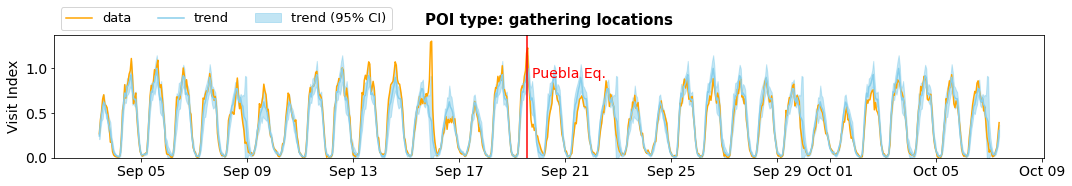

In [21]:
cats = ['airport', 'hospital', 'market', 'park', 'shelter']
cats = ["shelter",]
how = "type"

fig=plt.figure(figsize=(15,2.8*len(cats)))
gs=GridSpec(len(cats),1)

for i,c in enumerate(cats):
    ax = fig.add_subplot(gs[i,0]) 
    avg = get_trend_compare(df_poi, how, c)
    plot_trend_compare(avg, how, c, True, ax)
            
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/visittrend_all.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### Who came to shelter locations? 

In [24]:
shelters = set(df_poi[df_poi["type"]=="shelter"]["name"])

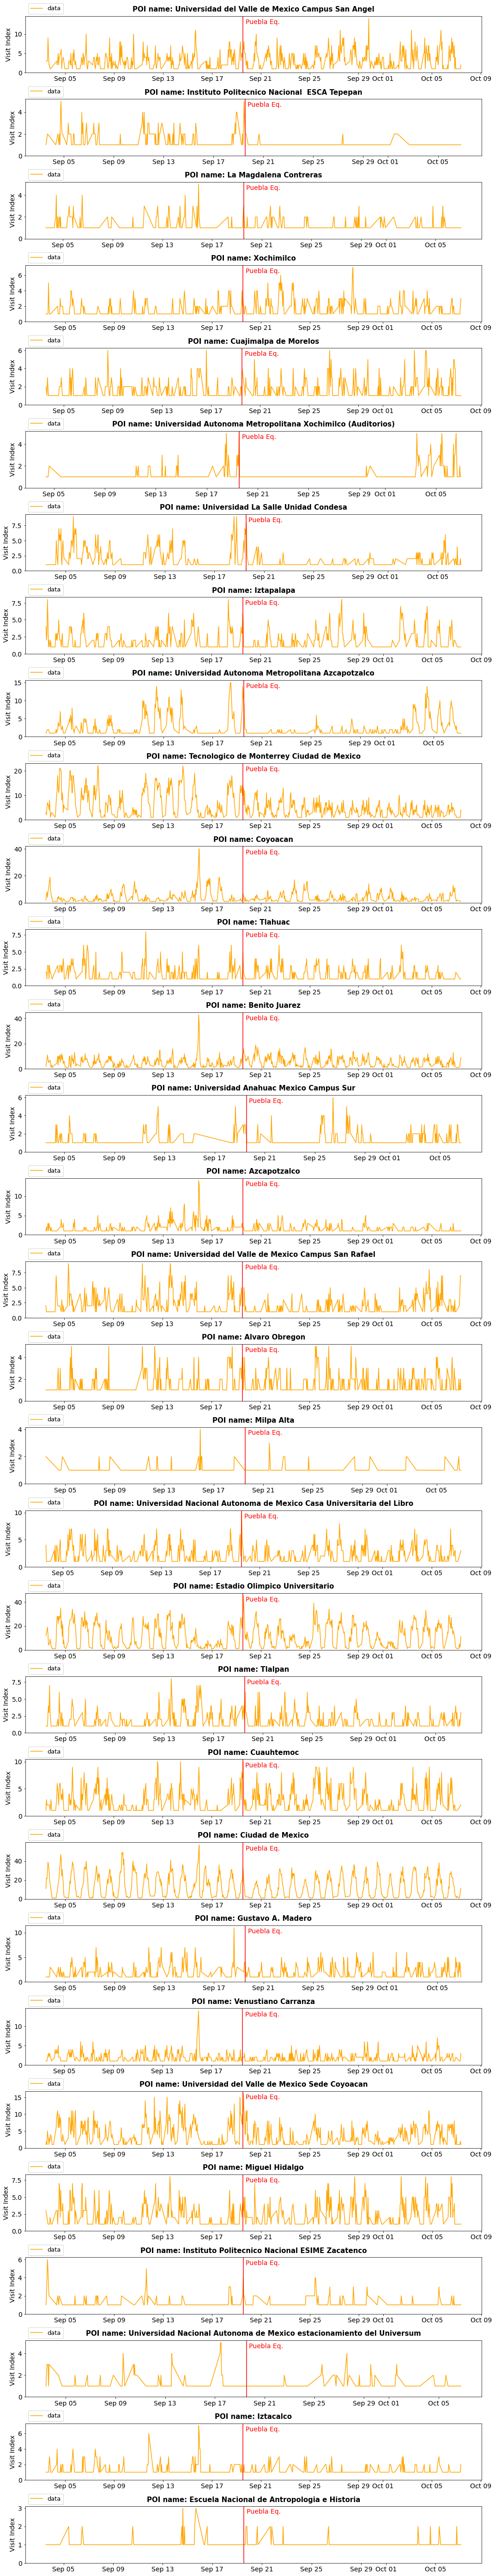

In [26]:
cats = shelters
how = "name"

fig=plt.figure(figsize=(15,2.5*len(cats)))
gs=GridSpec(len(cats),1)

for i,c in enumerate(cats):
    ax = fig.add_subplot(gs[i,0]) 
    avg = get_trend_compare(df_poi, how, c)
    plot_trend_compare(avg, how, c, False, ax)
            
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/visittrend_all.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### Shelter origin

In [ ]:
shelterloc = df_poi.copy() # pd.read_csv("D:/WB_Mexico/spatialdata/POIdata_new/POI_shelters.csv")
shelterloc["date"] = shelterloc["date_dt"].values

In [ ]:
df_shel = shelterloc.copy()
df_shel["day"] = df_shel["date_dt"].dt.floor("1d")

In [31]:
top = df_shel.groupby("name").sum().reset_index().sort_values("num_users", ascending=False)["name"].values
top

array(['Ciudad de Mexico', 'Estadio Olimpico Universitario',
       'Tecnologico de Monterrey Ciudad de Mexico', 'Benito Juarez',
       'Coyoacan', 'Universidad del Valle de Mexico Sede Coyoacan',
       'Universidad del Valle de Mexico Campus San Angel', 'Cuauhtemoc',
       'Universidad Autonoma Metropolitana Azcapotzalco',
       'Universidad Nacional Autonoma de Mexico Casa Universitaria del Libro',
       'Miguel Hidalgo',
       'Universidad del Valle de Mexico Campus San Rafael',
       'Venustiano Carranza', 'Iztapalapa', 'Gustavo A. Madero',
       'Tlalpan', 'Alvaro Obregon', 'Tlahuac',
       'Universidad La Salle Unidad Condesa', 'Azcapotzalco',
       'Cuajimalpa de Morelos', 'Xochimilco', 'Iztacalco',
       'Universidad Anahuac Mexico Campus Sur', 'La Magdalena Contreras',
       'Instituto Politecnico Nacional  ESCA Tepepan',
       'Instituto Politecnico Nacional ESIME Zacatenco',
       'Universidad Autonoma Metropolitana Xochimilco (Auditorios)',
       'Universidad

In [34]:
id_home_feat = df_idhome.copy()

In [35]:
from haversine import haversine
def getvisitinfo(tmp_shelter, date):
    befday = df_shel[df_shel["day"].isin(list(date))]
    befday_sub = befday[befday["name"]==tmp_shelter["name"]]
    allids = []
    for ids in befday_sub["users"]:
        for i in ids:
            if i!="":
                allids.append(i)
    allids_set = list(set(allids))
    ids_here = id_home_feat[id_home_feat["uid"].isin(allids_set)].copy()
    lat, lon = tmp_shelter["poilat"], tmp_shelter["poilon"]
    if ids_here.shape[0] > 0:
        ids_here = ids_here.assign(distance=ids_here.apply(lambda row: haversine([row["homelat"],row["homelon"]],
                                                                [lat, lon]), axis=1))
    else:
        ids_here["distance"] = []
    return ids_here

In [36]:
date1 = [dt.strptime(s, "%Y%m%d") for s in ["20170912","20170913","20170914",
                                            "20170915","20170916","20170917","20170918"]]
date2 = [dt.strptime(s, "%Y%m%d") for s in ["20170919","20170920","20170921",
                                            "20170922","20170923","20170924","20170925"]]

variable = "distance"

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


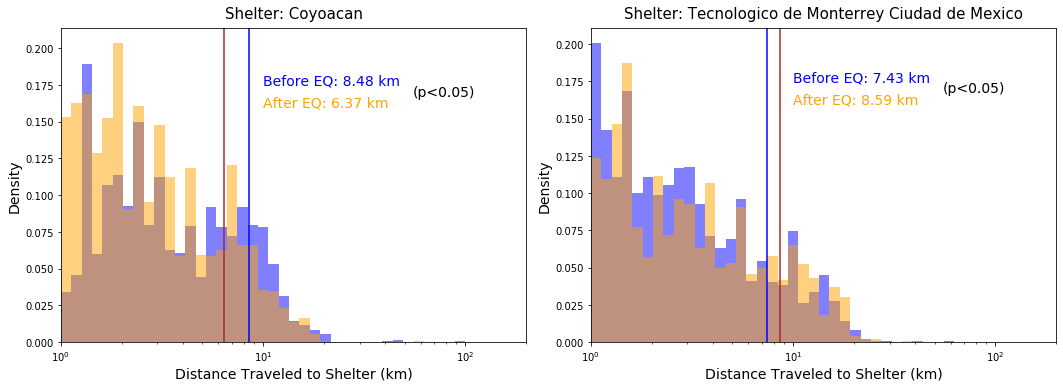

In [258]:
fig=plt.figure(figsize=(15,5.5))
gs=GridSpec(1,2)

i=0
for shelter in set(befday["name"]):
    latlon = shelterloc[shelterloc["NOMBRE"]==shelter][["LATITUD","LONGITUD"]]
    lat = latlon["LATITUD"].values[0]
    lon = latlon["LONGITUD"].values[0]
    bef = getvisitinfo(shelter,date1)
    aft = getvisitinfo(shelter,date2)

    maxdist = np.max((np.max(bef[variable].values),np.max(aft[variable].values)))
    res = stats.ttest_ind(bef[variable].values, aft[variable].values, equal_var = False)
    if res[1]<0.05:
        ax = fig.add_subplot(gs[0,i]) 
#         fig,ax = plt.subplots(figsize=(7,4))
        ax.hist(bef[variable].values,bins=np.logspace(0, int(np.log10(maxdist)), 40),
                density=True,alpha=.5, color="b")
        ax.axvline(np.mean(bef[variable].values), color="b")
        ax.hist(aft[variable].values,bins=np.logspace(0, int(np.log10(maxdist)), 40), 
                density=True,alpha=.5, color="orange")
        ax.axvline(np.mean(aft[variable].values), color="brown")
        ax.set_xlabel("Distance Traveled to Shelter (km)", fontsize=14)
        ax.set_xlim(1,200)
        ax.set_ylabel("Density", fontsize=14)
        ax.set_title("Shelter: "+shelter, fontsize=15, pad=10)
        ax.annotate("Before EQ: "+str(np.mean(bef[variable].values))[:4]+" km", 
                    xy=(10,0.175), color="b", fontsize=14)
        ax.annotate("After EQ: "+str(np.mean(aft[variable].values))[:4]+" km", 
                    xy=(10,0.16), color="orange", fontsize=14)
        ax.annotate("(p<0.05)", 
            xy=(55,0.1675), color="k", fontsize=14)

#         print(,np.std(bef[variable].values))
#         print(np.mean(aft[variable].values),np.std(aft[variable].values))
#         print("--")
        ax.set_xscale("log")
        i+=1
plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/shelter_dist.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### By economic deprovation

In [38]:
variable = "index_pca"

def getshelters(variable):
    df = pd.DataFrame()
    for shelter in set(befday["name"]):
        latlon = shelterloc[shelterloc["NOMBRE"]==shelter][["LATITUD","LONGITUD"]]
        lat = latlon["LATITUD"].values[0]
        lon = latlon["LONGITUD"].values[0]
        bef = getvisitinfo(shelter,date1)
        aft = getvisitinfo(shelter,date2)
        dist = np.mean(aft[variable].values)
        df = df.append({"shelter":shelter, "dist":dist, "lon":lon, "lat":lat}, ignore_index=True)
    df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), 
                              crs= {"init": "epsg:4326"}).to_crs(epsg=3857)
    return df_gdf

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


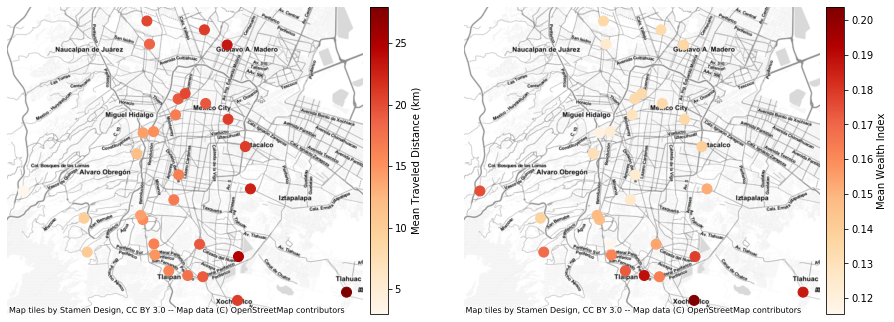

In [302]:
fig=plt.figure(figsize=(15,8))
gs=GridSpec(1,2)

ax = fig.add_subplot(gs[0,0]) 
divider = make_axes_locatable(ax)
df_gdf = getshelters("distance")
cax = divider.append_axes("right", size="5%", pad=0.1)
df_gdf.plot(ax=ax, column='dist', cmap='OrRd', legend=True, markersize=100, 
                    cax=cax, legend_kwds={'label': "Mean Traveled Distance (km)"}, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

ax2 = fig.add_subplot(gs[0,1]) 
divider = make_axes_locatable(ax2)
df_gdf = getshelters("index_pca")
cax = divider.append_axes("right", size="5%", pad=0.1)
df_gdf.plot(ax=ax2, column='dist', cmap='OrRd', legend=True, markersize=100, 
                    cax=cax, legend_kwds={'label': "Mean Wealth Index"}, alpha=1)
ctx.add_basemap(ax2, source=ctx.providers.Stamen.TonerLite)
ax2.set_axis_off()

# plt.savefig("C:/users/yabec/desktop/shelters_distance.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()